# Shipping Data Integration for Climate Commodity Analysis

## Introduction

To improve the model's ability to recognize when climate-driven pricing breaks down—especially during periods of global disruption—we introduce a bootstrapped approach that adds external economic signals to our dataset. 

The idea is that climate alone cannot explain all price movements, particularly during events like the COVID-19 pandemic, where supply chain issues caused prices to spike even though weather conditions were stable. 

To capture this broader economic stress, we "bootstrap" additional data into our model by integrating global shipping costs, using monthly freight indexes from sources like the Federal Reserve (FRED). These shipping costs serve as a proxy for supply chain tension and trade disruptions.

Once merged into our dataset, we engineer dynamic features like monthly changes, volatility, and momentum in shipping prices. These become part of a new set of "shock signals" that help the model detect when market conditions have shifted in a way that traditional weather variables can't explain. This enables the meta-model (in the Markovian Momentum framework) to adapt its trust in climate-based predictions and better account for real-world complexity.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set up plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## Load Datasets

First, we'll load the master commodity dataset and the shipping freight cost data.

In [2]:
# Define file paths
master_data_path = '/Users/Apexr/Documents/Climate_Project/organized/data_files/MASTER_climate_commodity_data.csv'
shipping_data_path = '/Users/Apexr/Downloads/PCU483111483111.csv'

# Load the master dataset
master_df = pd.read_csv(master_data_path)

# Convert date to datetime
master_df['Date'] = pd.to_datetime(master_df['Date'])

# Load the shipping data
shipping_df = pd.read_csv(shipping_data_path)

# Rename columns for clarity
shipping_df = shipping_df.rename(columns={'observation_date': 'Date', 'PCU483111483111': 'Shipping_Cost_Index'})

# Convert date to datetime
shipping_df['Date'] = pd.to_datetime(shipping_df['Date'])

# Display basic information
print(f"Master dataset shape: {master_df.shape}")
print(f"Master dataset date range: {master_df['Date'].min()} to {master_df['Date'].max()}")
print(f"\nShipping data shape: {shipping_df.shape}")
print(f"Shipping data date range: {shipping_df['Date'].min()} to {shipping_df['Date'].max()}")

Master dataset shape: (95, 87)
Master dataset date range: 2015-02-01 00:00:00 to 2022-12-01 00:00:00

Shipping data shape: (442, 2)
Shipping data date range: 1988-06-01 00:00:00 to 2025-03-01 00:00:00


## Examine The Datasets

Let's take a look at the first few rows of each dataset to understand their structure.

In [3]:
# Display the first few rows of the master dataset
print("Master Dataset:")
master_df.head(3)

Master Dataset:


,Date,Year,Month,Wheat_Price,Cocoa_Price,Rice_Price,Soybeans_Price,Coffee_Price,Maize_Price,Cotton_Price,Wheat_Region,Cocoa_Region,Rice_Region,Soybeans_Region,Coffee_Region,Maize_Region,Cotton_Region,Wheat_temperature_C,Wheat_precip_m,Wheat_dewpoint_C,Wheat_relative_humidity,Wheat_temp_anomaly,Wheat_precip_anomaly,Wheat_temp_3m_avg,Wheat_precip_3m_sum,Wheat_drought_index,Wheat_heat_stress,Cocoa_temperature_C,Cocoa_precip_m,Cocoa_dewpoint_C,Cocoa_relative_humidity,Cocoa_temp_anomaly,Cocoa_precip_anomaly,Cocoa_temp_3m_avg,Cocoa_precip_3m_sum,Cocoa_drought_index,Cocoa_heat_stress,Rice_temperature_C,Rice_precip_m,Rice_dewpoint_C,Rice_relative_humidity,Rice_temp_anomaly,Rice_precip_anomaly,Rice_temp_3m_avg,Rice_precip_3m_sum,Rice_drought_index,Rice_heat_stress,Soybeans_temperature_C,Soybeans_precip_m,Soybeans_dewpoint_C,Soybeans_relative_humidity,Soybeans_temp_anomaly,Soybeans_precip_anomaly,Soybeans_temp_3m_avg,Soybeans_precip_3m_sum,Soybeans_drought_index,Soybeans_heat_stress,Coffee_temperature_C,Coffee_precip_m,Coffee_dewpoint_C,Coffee_relative_humidity,Coffee_temp_anomaly,Coffee_precip_anomaly,Coffee_temp_3m_avg,Coffee_precip_3m_sum,Coffee_drought_index,Coffee_heat_stress,Maize_temperature_C,Maize_precip_m,Maize_dewpoint_C,Maize_relative_humidity,Maize_temp_anomaly,Maize_precip_anomaly,Maize_temp_3m_avg,Maize_precip_3m_sum,Maize_drought_index,Maize_heat_stress,Cotton_temperature_C,Cotton_precip_m,Cotton_dewpoint_C,Cotton_relative_humidity,Cotton_temp_anomaly,Cotton_precip_anomaly,Cotton_temp_3m_avg,Cotton_precip_3m_sum,Cotton_drought_index,Cotton_heat_stress
0,2015-02-01,2015,2,201.742069,2961.935714,409.500000,364.739239,178.888500,173.758866,69.842500,US GREAT PLAINS,GHANA,SOUTHEAST ASIA,BRAZIL SOY BELT,COLOMBIA,US CORN BELT,INDIA COTTON,25.938013,0.021711,19.968565,69.716495,-2.634213,0.000163,25.938013,0.021711,0.263584,29.423837,30.146202,0.040482,23.713093,68.580399,1.324871,-0.009216,30.146202,0.040482,-0.141703,33.575222,26.982498,0.030509,20.657769,68.408091,0.470796,0.004697,26.982498,0.030509,-0.042383,30.402902,14.269318,0.005841,9.113065,71.151334,1.043072,-0.007197,14.269318,0.005841,-0.111504,17.826885,22.072321,0.038221,17.746410,76.520422,-0.608285,-0.006239,22.072321,0.038221,0.054590,25.898342,27.739582,0.031813,22.084914,71.417513,0.478354,0.003123,27.739582,0.031813,-0.044712,31.310458,24.473500,0.024623,17.390874,64.743134,-2.004087,-0.005370,24.473500,0.024623,0.195039,27.710657
1,2015-03-01,2015,3,202.691427,2878.033167,400.727273,359.595560,160.735909,174.293821,69.352273,US GREAT PLAINS,GHANA,SOUTHEAST ASIA,BRAZIL SOY BELT,COLOMBIA,US CORN BELT,INDIA COTTON,30.267190,0.022776,24.297743,70.536420,0.114860,-0.001884,28.102601,0.044487,-0.013370,33.794011,27.706814,0.053458,21.273705,68.098480,-1.546187,0.002868,28.926508,0.093940,0.157487,31.111738,26.694945,0.028264,20.370216,68.350895,-1.143673,-0.000082,26.838721,0.058773,0.114285,30.112490,11.179879,0.010875,6.023626,70.542550,-0.410643,-0.001187,12.724599,0.016716,0.039878,14.707006,23.006479,0.044857,18.680568,76.668287,0.350725,-0.002067,22.539400,0.083078,-0.037140,26.839893,28.747019,0.032787,23.092351,71.601167,0.386766,0.002788,28.243301,0.064600,-0.035889,32.327078,28.214707,0.023812,21.132081,65.545173,0.221311,-0.005282,26.344103,0.048435,-0.027413,31.491965
2,2015-04-01,2015,4,195.931228,2868.274454,392.409091,356.925677,163.997727,172.151577,71.702500,US GREAT PLAINS,GHANA,SOUTHEAST ASIA,BRAZIL SOY BELT,COLOMBIA,US CORN BELT,INDIA COTTON,27.174480,0.023657,21.205033,69.953842,-0.604942,0.000875,27.793228,0.068144,0.061369,30.672172,28.287590,0.049797,21.854482,68.214125,-0.590174,-0.003297,28.713535,0.143738,0.055720,31.698296,27.378898,0.030846,21.054170,68.486707,0.128293,0.001015,27.018780,0.089618,-0.011815,30.803233,11.992816,0.012307,6.836563,70.704447,-1.125529,0.000819,12.480671,0.029023,0.113372,15.528038,23.735533,0.042551,19.409622,76.782773,1.461737,0.000227,22.938111,0.125629,-0.145947,27.574672,27.455673,0.031946,21.801005,7

In [4]:
# Display the first few rows of the shipping data
print("Shipping Data:")
shipping_df.head(3)

Shipping Data:


,Date,Shipping_Cost_Index
0,1988-06-01,100.0
1,1988-07-01,104.2
2,1988-08-01,102.6


## Filter Datasets to Matching Time Periods

We'll filter both datasets to ensure they cover the same time period for proper merging.

In [5]:
# Get the overlapping date range
start_date = max(master_df['Date'].min(), shipping_df['Date'].min())
end_date = min(master_df['Date'].max(), shipping_df['Date'].max())

print(f"Overlapping date range: {start_date} to {end_date}")

# Filter both datasets to the overlapping range
master_filtered = master_df[(master_df['Date'] >= start_date) & (master_df['Date'] <= end_date)]
shipping_filtered = shipping_df[(shipping_df['Date'] >= start_date) & (shipping_df['Date'] <= end_date)]

print(f"\nFiltered master dataset shape: {master_filtered.shape}")
print(f"Filtered shipping data shape: {shipping_filtered.shape}")

Overlapping date range: 2015-02-01 00:00:00 to 2022-12-01 00:00:00

Filtered master dataset shape: (95, 87)
Filtered shipping data shape: (95, 2)


## Merge the Datasets

Now we'll merge the shipping data with the master commodity dataset.

In [6]:
# Merge the datasets on the Date column
merged_df = pd.merge(master_filtered, shipping_filtered, on='Date', how='left')

# Check for any missing values in the shipping cost column
missing_shipping = merged_df['Shipping_Cost_Index'].isna().sum()
print(f"Number of rows with missing shipping data: {missing_shipping}")

# If there are missing values, fill them using forward fill (using the last known value)
if missing_shipping > 0:
    merged_df['Shipping_Cost_Index'] = merged_df['Shipping_Cost_Index'].fillna(method='ffill')
    print("Filled missing values using forward fill method.")

# Display the merged dataset
print(f"\nMerged dataset shape: {merged_df.shape}")
merged_df.head(3)

Number of rows with missing shipping data: 0

Merged dataset shape: (95, 88)


,Date,Year,Month,Wheat_Price,Cocoa_Price,Rice_Price,Soybeans_Price,Coffee_Price,Maize_Price,Cotton_Price,Wheat_Region,Cocoa_Region,Rice_Region,Soybeans_Region,Coffee_Region,Maize_Region,Cotton_Region,Wheat_temperature_C,Wheat_precip_m,Wheat_dewpoint_C,Wheat_relative_humidity,Wheat_temp_anomaly,Wheat_precip_anomaly,Wheat_temp_3m_avg,Wheat_precip_3m_sum,Wheat_drought_index,Wheat_heat_stress,Cocoa_temperature_C,Cocoa_precip_m,Cocoa_dewpoint_C,Cocoa_relative_humidity,Cocoa_temp_anomaly,Cocoa_precip_anomaly,Cocoa_temp_3m_avg,Cocoa_precip_3m_sum,Cocoa_drought_index,Cocoa_heat_stress,Rice_temperature_C,Rice_precip_m,Rice_dewpoint_C,Rice_relative_humidity,Rice_temp_anomaly,Rice_precip_anomaly,Rice_temp_3m_avg,Rice_precip_3m_sum,Rice_drought_index,Rice_heat_stress,Soybeans_temperature_C,Soybeans_precip_m,Soybeans_dewpoint_C,Soybeans_relative_humidity,Soybeans_temp_anomaly,Soybeans_precip_anomaly,Soybeans_temp_3m_avg,Soybeans_precip_3m_sum,Soybeans_drought_index,Soybeans_heat_stress,Coffee_temperature_C,Coffee_precip_m,Coffee_dewpoint_C,Coffee_relative_humidity,Coffee_temp_anomaly,Coffee_precip_anomaly,Coffee_temp_3m_avg,Coffee_precip_3m_sum,Coffee_drought_index,Coffee_heat_stress,Maize_temperature_C,Maize_precip_m,Maize_dewpoint_C,Maize_relative_humidity,Maize_temp_anomaly,Maize_precip_anomaly,Maize_temp_3m_avg,Maize_precip_3m_sum,Maize_drought_index,Maize_heat_stress,Cotton_temperature_C,Cotton_precip_m,Cotton_dewpoint_C,Cotton_relative_humidity,Cotton_temp_anomaly,Cotton_precip_anomaly,Cotton_temp_3m_avg,Cotton_precip_3m_sum,Cotton_drought_index,Cotton_heat_stress,Shipping_Cost_Index
0,2015-02-01,2015,2,201.742069,2961.935714,409.500000,364.739239,178.888500,173.758866,69.842500,US GREAT PLAINS,GHANA,SOUTHEAST ASIA,BRAZIL SOY BELT,COLOMBIA,US CORN BELT,INDIA COTTON,25.938013,0.021711,19.968565,69.716495,-2.634213,0.000163,25.938013,0.021711,0.263584,29.423837,30.146202,0.040482,23.713093,68.580399,1.324871,-0.009216,30.146202,0.040482,-0.141703,33.575222,26.982498,0.030509,20.657769,68.408091,0.470796,0.004697,26.982498,0.030509,-0.042383,30.402902,14.269318,0.005841,9.113065,71.151334,1.043072,-0.007197,14.269318,0.005841,-0.111504,17.826885,22.072321,0.038221,17.746410,76.520422,-0.608285,-0.006239,22.072321,0.038221,0.054590,25.898342,27.739582,0.031813,22.084914,71.417513,0.478354,0.003123,27.739582,0.031813,-0.044712,31.310458,24.473500,0.024623,17.390874,64.743134,-2.004087,-0.005370,24.473500,0.024623,0.195039,27.710657,267.4
1,2015-03-01,2015,3,202.691427,2878.033167,400.727273,359.595560,160.735909,174.293821,69.352273,US GREAT PLAINS,GHANA,SOUTHEAST ASIA,BRAZIL SOY BELT,COLOMBIA,US CORN BELT,INDIA COTTON,30.267190,0.022776,24.297743,70.536420,0.114860,-0.001884,28.102601,0.044487,-0.013370,33.794011,27.706814,0.053458,21.273705,68.098480,-1.546187,0.002868,28.926508,0.093940,0.157487,31.111738,26.694945,0.028264,20.370216,68.350895,-1.143673,-0.000082,26.838721,0.058773,0.114285,30.112490,11.179879,0.010875,6.023626,70.542550,-0.410643,-0.001187,12.724599,0.016716,0.039878,14.707006,23.006479,0.044857,18.680568,76.668287,0.350725,-0.002067,22.539400,0.083078,-0.037140,26.839893,28.747019,0.032787,23.092351,71.601167,0.386766,0.002788,28.243301,0.064600,-0.035889,32.327078,28.214707,0.023812,21.132081,65.545173,0.221311,-0.005282,26.344103,0.048435,-0.027413,31.491965,268.1
2,2015-04-01,2015,4,195.931228,2868.274454,392.409091,356.925677,163.997727,172.151577,71.702500,US GREAT PLAINS,GHANA,SOUTHEAST ASIA,BRAZIL SOY BELT,COLOMBIA,US CORN BELT,INDIA COTTON,27.174480,0.023657,21.205033,69.953842,-0.604942,0.000875,27.793228,0.068144,0.061369,30.672172,28.287590,0.049797,21.854482,68.214125,-0.590174,-0.003297,28.713535,0.143738,0.055720,31.698296,27.378898,0.030846,21.054170,68.486707,0.128293,0.001015,27.018780,0.089618,-0.011815,30.803233,11.992816,0.012307,6.836563,70.704447,-1.125529,0.000819,12.480671,0.029023,0.113372,15.528038,23.735533,0.042551,19.409622,76.782773,1.461737,0.000227,22.938111,0.125629,-0.145947,27.57467

## Create Shipping-Related Features

We'll create several features from the shipping cost data to serve as "shock signals" for our Markovian Momentum Model.

In [7]:
# 1. Monthly change in shipping costs (first derivative)
merged_df['Shipping_Cost_Change'] = merged_df['Shipping_Cost_Index'].diff()

# 2. Rate of change in shipping costs (percentage change)
merged_df['Shipping_Cost_Pct_Change'] = merged_df['Shipping_Cost_Index'].pct_change() * 100

# 3. Acceleration in shipping costs (second derivative - the "Δ² P" in our model)
merged_df['Shipping_Cost_Acceleration'] = merged_df['Shipping_Cost_Change'].diff()

# 4. Shipping cost volatility (3-month rolling standard deviation)
merged_df['Shipping_Cost_Volatility'] = merged_df['Shipping_Cost_Index'].rolling(window=3).std()

# 5. Change in volatility (the "d/dt σ" in our model)
merged_df['Shipping_Volatility_Change'] = merged_df['Shipping_Cost_Volatility'].diff()

# 6. Shipping cost anomaly (deviation from 12-month moving average)
merged_df['Shipping_Cost_12m_Avg'] = merged_df['Shipping_Cost_Index'].rolling(window=12, min_periods=1).mean()
merged_df['Shipping_Cost_Anomaly'] = merged_df['Shipping_Cost_Index'] - merged_df['Shipping_Cost_12m_Avg']

# 7. Shock indicator (composite score based on multiple signals)
# Normalize each component to 0-1 range for equal weighting
max_acc = merged_df['Shipping_Cost_Acceleration'].abs().max()
max_vol_change = merged_df['Shipping_Volatility_Change'].abs().max()
max_anomaly = merged_df['Shipping_Cost_Anomaly'].abs().max()

# Create normalized components (absolute values to capture both positive and negative shocks)
merged_df['Norm_Acceleration'] = merged_df['Shipping_Cost_Acceleration'].abs() / max_acc if max_acc > 0 else 0
merged_df['Norm_Vol_Change'] = merged_df['Shipping_Volatility_Change'].abs() / max_vol_change if max_vol_change > 0 else 0
merged_df['Norm_Anomaly'] = merged_df['Shipping_Cost_Anomaly'].abs() / max_anomaly if max_anomaly > 0 else 0

# Calculate composite shock score (simple average of normalized components)
merged_df['Shipping_Shock_Score'] = (merged_df['Norm_Acceleration'] + 
                                    merged_df['Norm_Vol_Change'] + 
                                    merged_df['Norm_Anomaly']) / 3

# Fill any NaN values in the new columns with 0
shock_columns = ['Shipping_Cost_Change', 'Shipping_Cost_Pct_Change', 'Shipping_Cost_Acceleration',
                 'Shipping_Cost_Volatility', 'Shipping_Volatility_Change', 'Shipping_Cost_Anomaly',
                 'Shipping_Shock_Score']
merged_df[shock_columns] = merged_df[shock_columns].fillna(0)

# Display the newly created features
merged_df[['Date', 'Shipping_Cost_Index'] + shock_columns].head(5)

,Date,Shipping_Cost_Index,Shipping_Cost_Change,Shipping_Cost_Pct_Change,Shipping_Cost_Acceleration,Shipping_Cost_Volatility,Shipping_Volatility_Change,Shipping_Cost_Anomaly,Shipping_Shock_Score
0,2015-02-01,267.4,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,2015-03-01,268.1,0.7,0.261780,0.0,0.000000,0.000000,0.350000,0.000000
2,2015-04-01,269.2,1.1,0.410295,0.4,0.907377,0.000000,0.966667,0.000000
3,2015-05-01,269.1,-0.1,-0.037147,-1.2,0.608276,-0.299101,0.650000,0.013661
4,2015-06-01,263.2,-5.9,-2.192493,-5.8,3.435598,2.827322,-4.200000,0.088783


## Visualize Shipping Cost Trends

Let's visualize the shipping cost trends over time to understand how they align with commodity price movements, especially during the COVID-19 period.

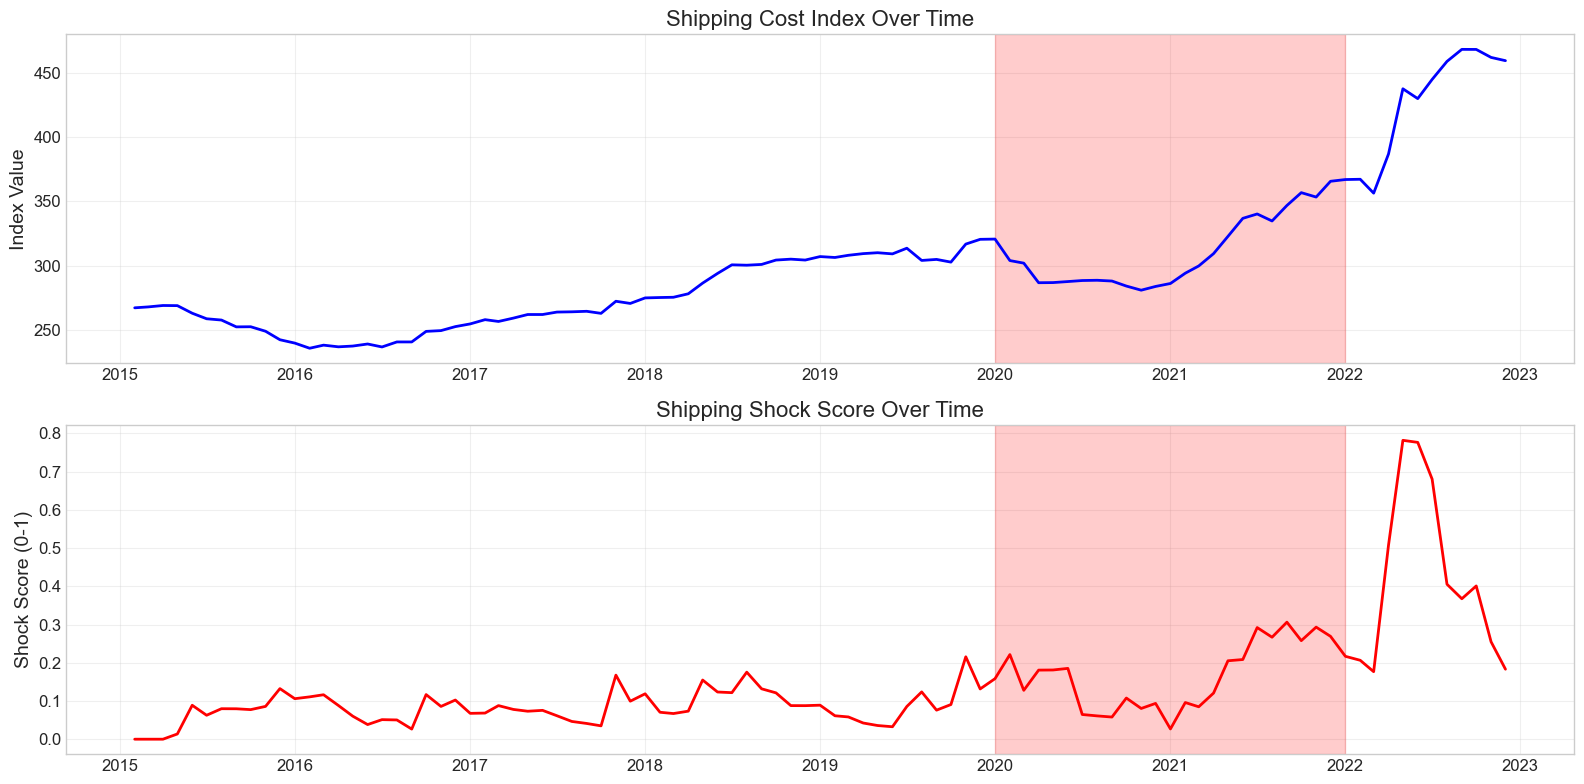

In [8]:
plt.figure(figsize=(16, 8))

# Plot shipping cost index
plt.subplot(2, 1, 1)
plt.plot(merged_df['Date'], merged_df['Shipping_Cost_Index'], color='blue', linewidth=2)
plt.title('Shipping Cost Index Over Time', fontsize=16)
plt.ylabel('Index Value', fontsize=14)
plt.grid(True, alpha=0.3)

# Highlight the COVID-19 period (2020-2021)
covid_start = pd.Timestamp('2020-01-01')
covid_end = pd.Timestamp('2021-12-31')
plt.axvspan(covid_start, covid_end, color='red', alpha=0.2, label='COVID-19 Period')

# Plot shock score
plt.subplot(2, 1, 2)
plt.plot(merged_df['Date'], merged_df['Shipping_Shock_Score'], color='red', linewidth=2)
plt.title('Shipping Shock Score Over Time', fontsize=16)
plt.ylabel('Shock Score (0-1)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.axvspan(covid_start, covid_end, color='red', alpha=0.2)

plt.tight_layout()
plt.show()

## Compare Shipping Costs with Commodity Prices

Now let's compare shipping costs with the commodity prices to see if there's a visible relationship, particularly during the COVID-19 period.

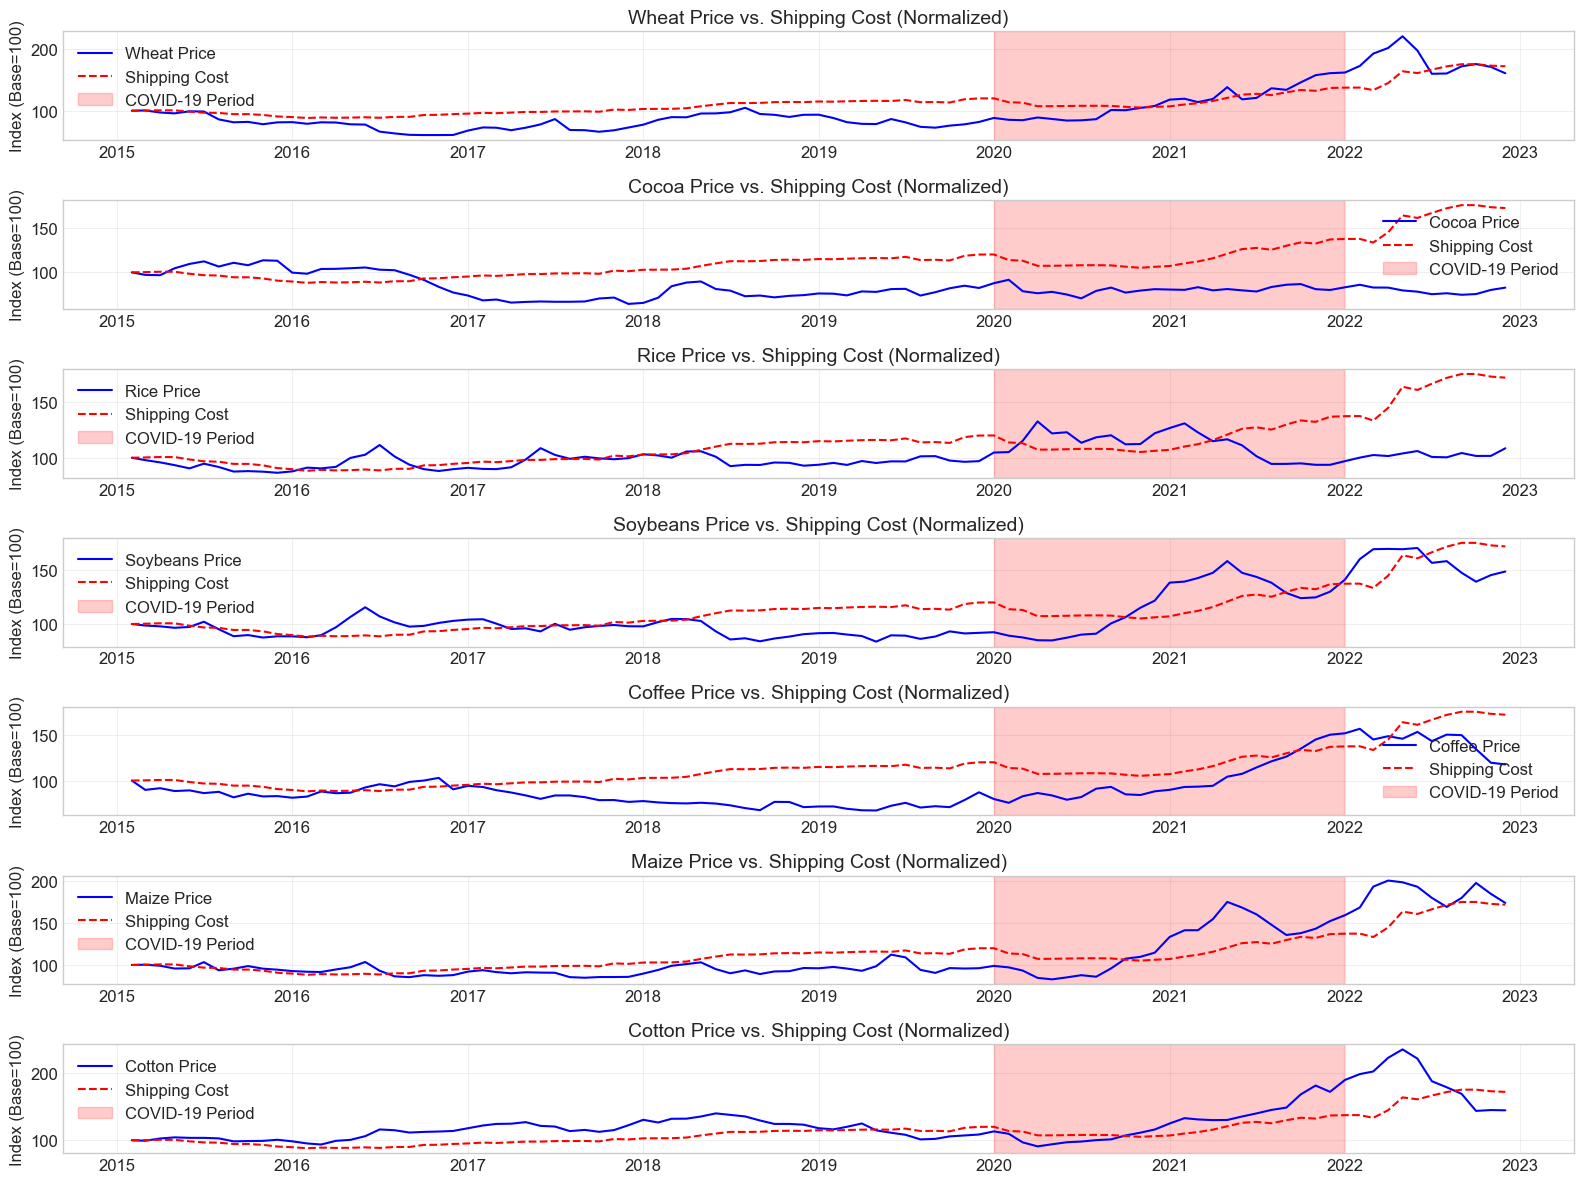

In [9]:
# Normalize both commodity prices and shipping costs for comparison (each series starts at 100)
plt.figure(figsize=(16, 12))

# Get list of commodities
commodities = [col.replace('_Price', '') for col in merged_df.columns if col.endswith('_Price')]

# Plot each commodity price with shipping index
for i, commodity in enumerate(commodities):
    plt.subplot(len(commodities), 1, i+1)
    
    # Normalize price series to start at 100
    price_col = f"{commodity}_Price"
    first_price = merged_df[price_col].iloc[0]
    norm_price = merged_df[price_col] / first_price * 100
    
    # Normalize shipping index to start at 100
    first_shipping = merged_df['Shipping_Cost_Index'].iloc[0]
    norm_shipping = merged_df['Shipping_Cost_Index'] / first_shipping * 100
    
    # Plot normalized series
    plt.plot(merged_df['Date'], norm_price, color='blue', label=f'{commodity} Price')
    plt.plot(merged_df['Date'], norm_shipping, color='red', linestyle='--', label='Shipping Cost')
    
    # Highlight COVID period
    plt.axvspan(covid_start, covid_end, color='red', alpha=0.2, label='COVID-19 Period')
    
    plt.title(f'{commodity} Price vs. Shipping Cost (Normalized)', fontsize=14)
    plt.ylabel('Index (Base=100)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
plt.tight_layout()
plt.show()

## Calculate Correlations

Let's calculate the correlations between shipping costs and commodity prices to quantify the relationships.

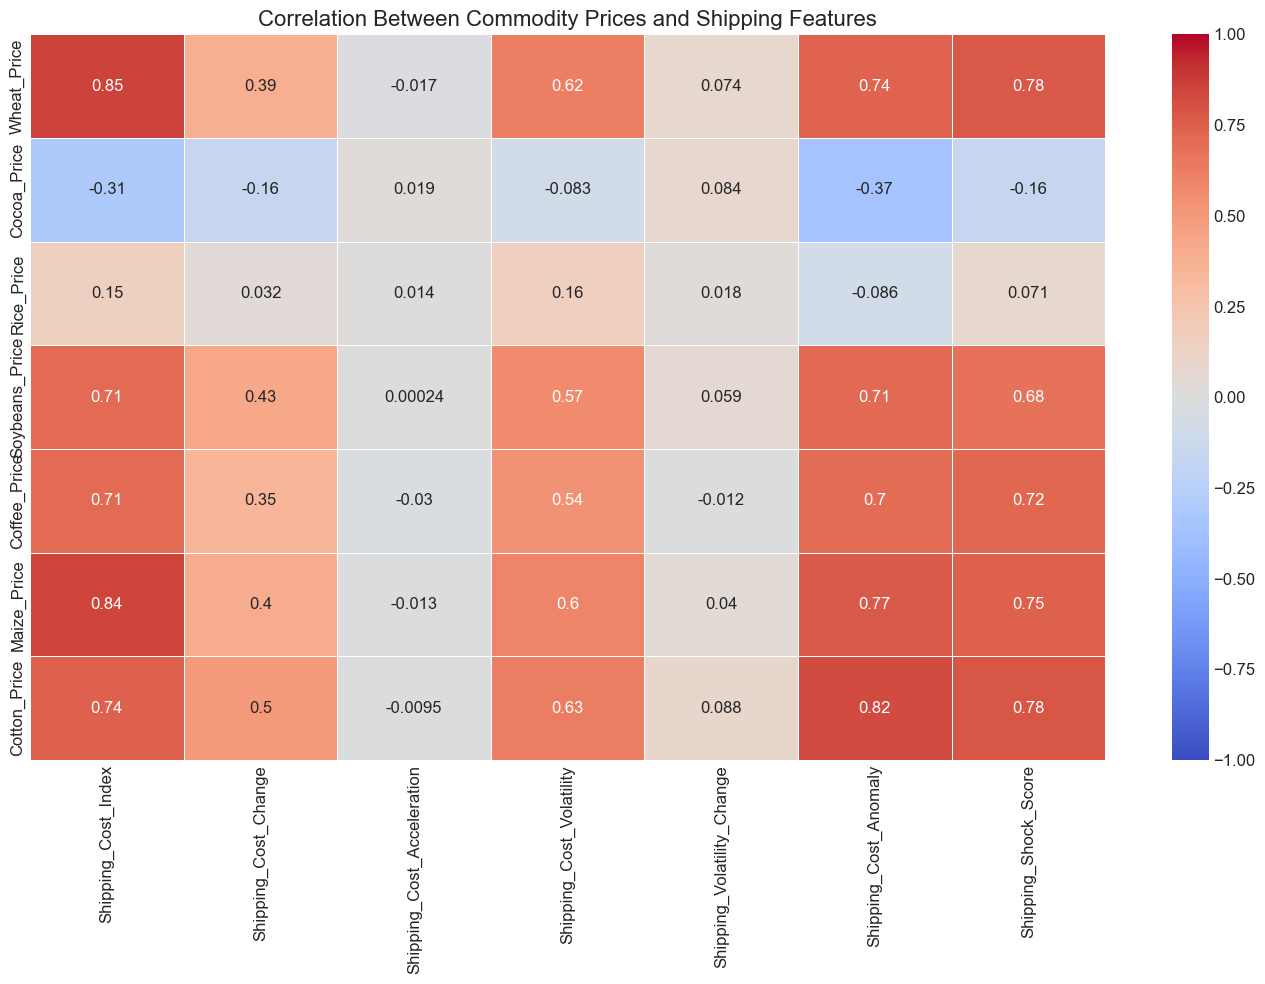

In [10]:
# Select price columns for correlation analysis
price_cols = [col for col in merged_df.columns if col.endswith('_Price')]

# Create correlation matrix between prices and shipping features
shipping_cols = ['Shipping_Cost_Index', 'Shipping_Cost_Change', 'Shipping_Cost_Acceleration',
                 'Shipping_Cost_Volatility', 'Shipping_Volatility_Change', 
                 'Shipping_Cost_Anomaly', 'Shipping_Shock_Score']

# Calculate correlations
corr_matrix = merged_df[price_cols + shipping_cols].corr()

# Extract just the correlations between prices and shipping features
price_shipping_corr = corr_matrix.loc[price_cols, shipping_cols]

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(price_shipping_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, linewidths=0.5)
plt.title('Correlation Between Commodity Prices and Shipping Features', fontsize=16)
plt.tight_layout()
plt.show()

## Split Correlations Before and During COVID-19

Let's compare correlations before and during the COVID-19 period to see if the relationships changed.

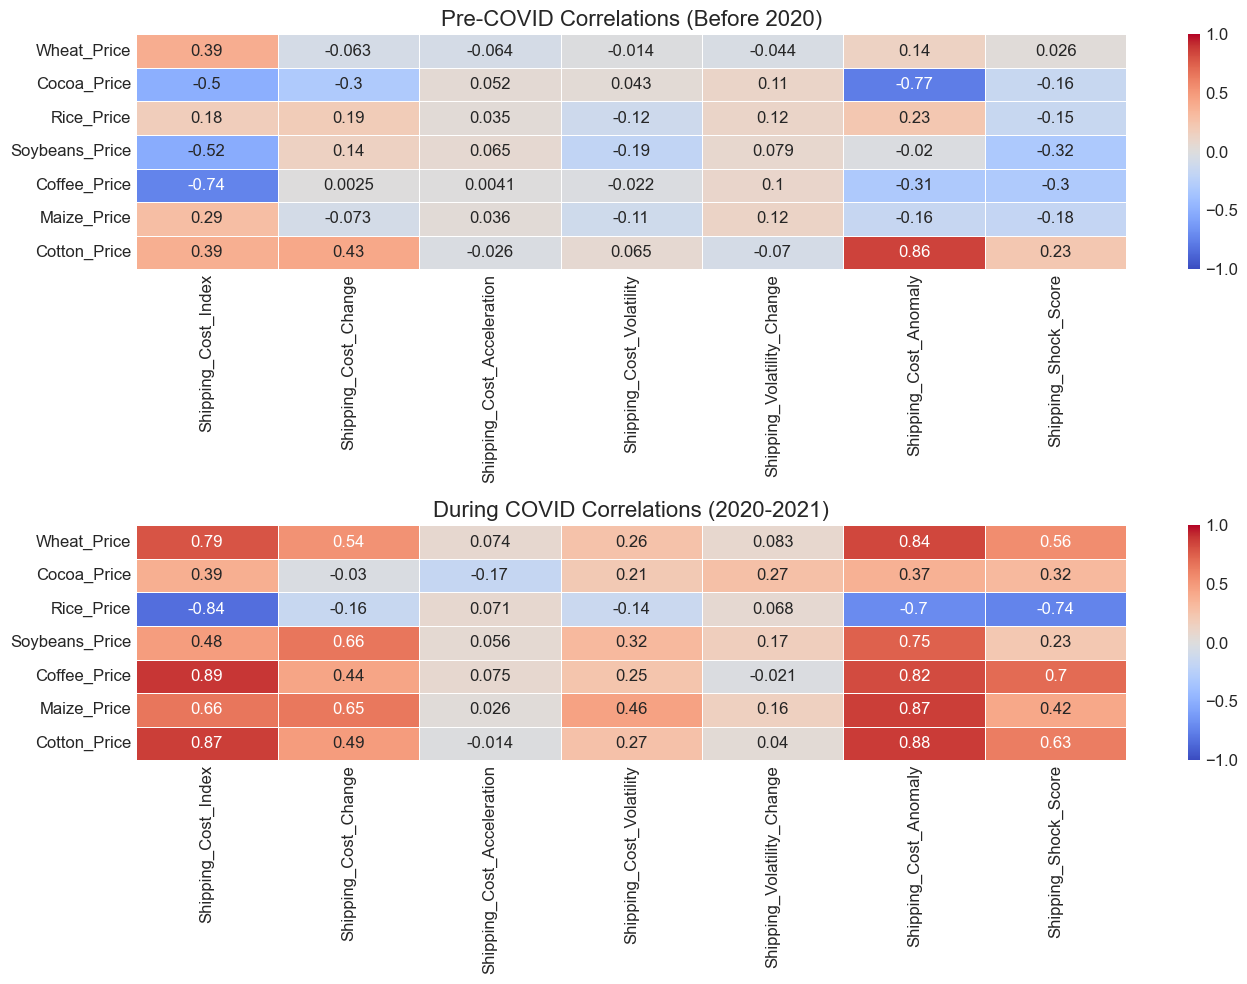

In [11]:
# Split data into pre-COVID and COVID periods
pre_covid = merged_df[merged_df['Date'] < covid_start]
during_covid = merged_df[(merged_df['Date'] >= covid_start) & (merged_df['Date'] <= covid_end)]

# Calculate correlations for pre-COVID period
pre_covid_corr = pre_covid[price_cols + shipping_cols].corr()
pre_covid_price_shipping = pre_covid_corr.loc[price_cols, shipping_cols]

# Calculate correlations for COVID period
covid_corr = during_covid[price_cols + shipping_cols].corr()
covid_price_shipping = covid_corr.loc[price_cols, shipping_cols]

# Plot pre-COVID correlations
plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
sns.heatmap(pre_covid_price_shipping, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, linewidths=0.5)
plt.title('Pre-COVID Correlations (Before 2020)', fontsize=16)

# Plot COVID correlations
plt.subplot(2, 1, 2)
sns.heatmap(covid_price_shipping, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, linewidths=0.5)
plt.title('During COVID Correlations (2020-2021)', fontsize=16)

plt.tight_layout()
plt.show()

## Analyze Coffee Price Specifically

Let's take a closer look at Coffee prices since this was our primary example in the model development.

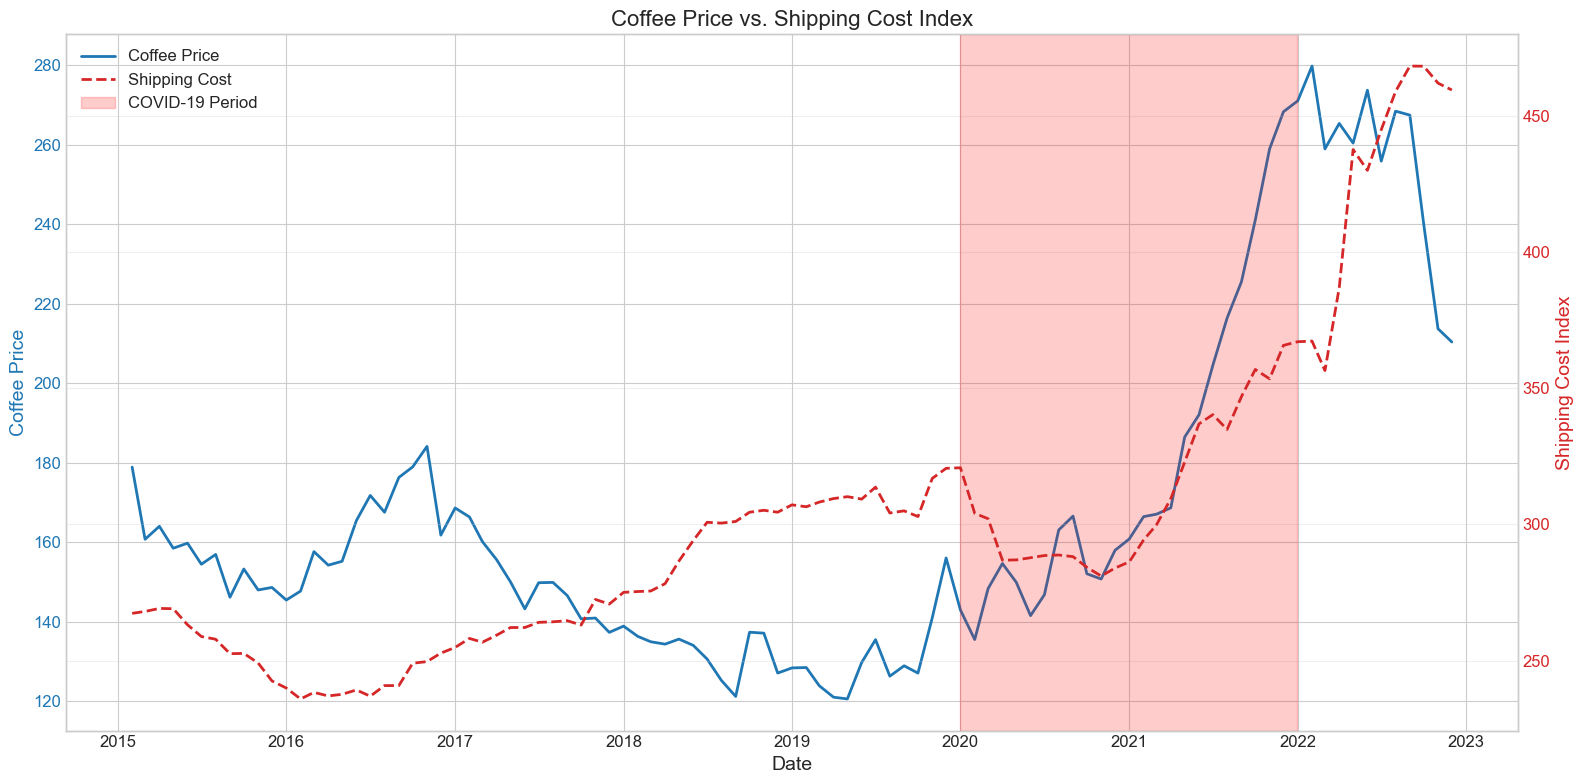

In [12]:
# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot Coffee Price on first axis
color = 'tab:blue'
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Coffee Price', color=color, fontsize=14)
ax1.plot(merged_df['Date'], merged_df['Coffee_Price'], color=color, linewidth=2, label='Coffee Price')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for shipping cost
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Shipping Cost Index', color=color, fontsize=14)
ax2.plot(merged_df['Date'], merged_df['Shipping_Cost_Index'], color=color, linewidth=2, linestyle='--', label='Shipping Cost')
ax2.tick_params(axis='y', labelcolor=color)

# Highlight the COVID-19 period
plt.axvspan(covid_start, covid_end, color='red', alpha=0.2, label='COVID-19 Period')

# Add a title and legend
plt.title('Coffee Price vs. Shipping Cost Index', fontsize=16)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Analyze the "Shock Signals" During COVID-19

Let's examine the shock signals during the COVID-19 period to see if they could have helped identify the breakdown in climate-price relationships.

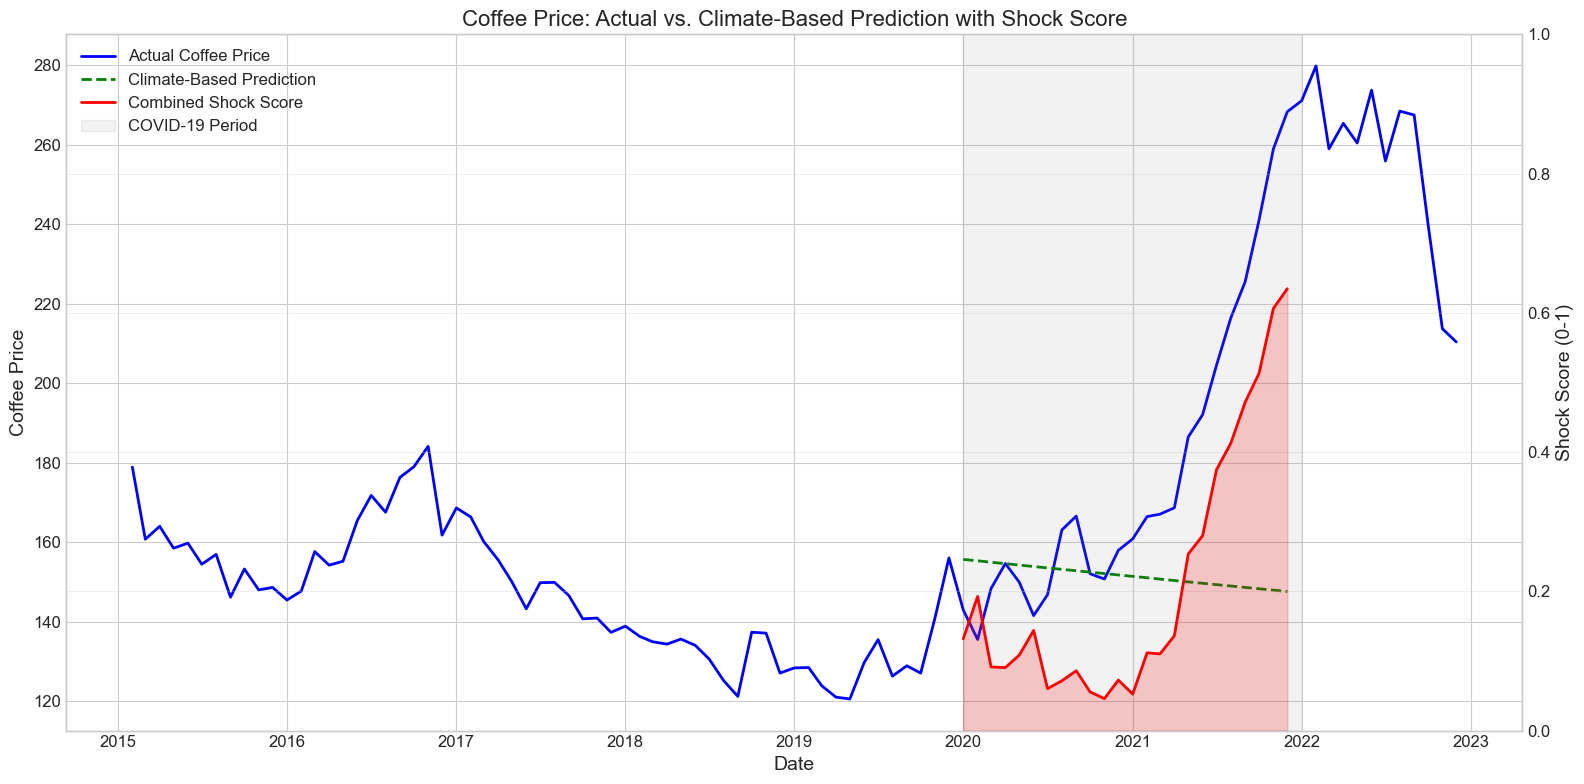

In [13]:
# Calculate model residuals (simulated)
# This would normally come from a trained model, but for illustration we'll create a simple estimate
# Assume a simple model based on the pre-COVID relationship between Coffee price and climate variables

# Use a simple average growth rate from pre-COVID to simulate predictions
pre_covid_coffee = pre_covid['Coffee_Price']
avg_monthly_growth = (pre_covid_coffee.iloc[-1] / pre_covid_coffee.iloc[0]) ** (1/len(pre_covid_coffee)) - 1

# Create simulated predictions based on pre-COVID patterns
merged_df['Coffee_Baseline_Pred'] = np.nan
last_pre_covid_price = pre_covid_coffee.iloc[-1]

for i, date in enumerate(during_covid['Date']):
    if i == 0:
        merged_df.loc[merged_df['Date'] == date, 'Coffee_Baseline_Pred'] = last_pre_covid_price * (1 + avg_monthly_growth)
    else:
        prev_pred = merged_df.loc[merged_df['Date'] == during_covid['Date'].iloc[i-1], 'Coffee_Baseline_Pred'].values[0]
        merged_df.loc[merged_df['Date'] == date, 'Coffee_Baseline_Pred'] = prev_pred * (1 + avg_monthly_growth)

# Calculate model residuals for the COVID period
merged_df['Coffee_Model_Residual'] = np.nan
merged_df.loc[merged_df['Date'] >= covid_start, 'Coffee_Model_Residual'] = \
    merged_df.loc[merged_df['Date'] >= covid_start, 'Coffee_Price'] - \
    merged_df.loc[merged_df['Date'] >= covid_start, 'Coffee_Baseline_Pred']

# Normalize residuals
max_residual = merged_df['Coffee_Model_Residual'].abs().max()
merged_df['Coffee_Norm_Residual'] = merged_df['Coffee_Model_Residual'].abs() / max_residual if max_residual > 0 else 0

# Create a combined shock indicator that includes both shipping shocks and model residuals
merged_df['Combined_Shock_Score'] = np.nan
merged_df.loc[merged_df['Date'] >= covid_start, 'Combined_Shock_Score'] = \
    (merged_df.loc[merged_df['Date'] >= covid_start, 'Shipping_Shock_Score'] + \
     merged_df.loc[merged_df['Date'] >= covid_start, 'Coffee_Norm_Residual']) / 2

# Plot actual price, model predictions, and shock score
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot prices on first axis
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Coffee Price', fontsize=14)
ax1.plot(merged_df['Date'], merged_df['Coffee_Price'], color='blue', linewidth=2, label='Actual Coffee Price')
ax1.plot(merged_df['Date'], merged_df['Coffee_Baseline_Pred'], color='green', linewidth=2, 
         linestyle='--', label='Climate-Based Prediction')
ax1.tick_params(axis='y')

# Create a second y-axis for shock score
ax2 = ax1.twinx()
ax2.set_ylabel('Shock Score (0-1)', fontsize=14)
ax2.plot(merged_df['Date'], merged_df['Combined_Shock_Score'], color='red', linewidth=2, 
         label='Combined Shock Score')
ax2.fill_between(merged_df['Date'], 0, merged_df['Combined_Shock_Score'], color='red', alpha=0.2)
ax2.tick_params(axis='y')
ax2.set_ylim(0, 1)

# Highlight the COVID-19 period
plt.axvspan(covid_start, covid_end, color='gray', alpha=0.1, label='COVID-19 Period')

# Add a title and legend
plt.title('Coffee Price: Actual vs. Climate-Based Prediction with Shock Score', fontsize=16)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Save the Enhanced Dataset

Finally, let's save the enhanced dataset with the shipping-related features for use in our Markovian Momentum Model.

In [14]:
# Select columns to save
# Keep all original columns plus the shipping-related features
columns_to_save = list(master_filtered.columns) + shipping_cols

# If we created simulated predictions and residuals, add those as well
if 'Coffee_Baseline_Pred' in merged_df.columns:
    columns_to_save.extend(['Coffee_Baseline_Pred', 'Coffee_Model_Residual', 'Coffee_Norm_Residual', 'Combined_Shock_Score'])

# Save to CSV
output_path = '/Users/Apexr/Documents/Climate_Project/organized/data_files/MASTER_climate_commodity_with_shipping.csv'
merged_df[columns_to_save].to_csv(output_path, index=False)

print(f"Enhanced dataset saved to: {output_path}")
print(f"Number of rows: {len(merged_df)}")
print(f"Number of columns: {len(columns_to_save)}")

Enhanced dataset saved to: /Users/Apexr/Documents/Climate_Project/organized/data_files/MASTER_climate_commodity_with_shipping.csv
Number of rows: 95
Number of columns: 98


## Conclusion

In this notebook, we've:  

1. Loaded and merged the master commodity dataset with shipping cost data from the Federal Reserve
2. Created several "shock signals" based on shipping costs:  
   - Shipping cost changes and acceleration
   - Shipping cost volatility and volatility changes
   - Shipping cost anomalies
   - A composite shock score
3. Visualized the relationship between shipping costs and commodity prices
4. Analyzed correlations before and during the COVID-19 period
5. Created a simulated example of how these shock signals could help improve predictions during disruption periods

The analysis shows that shipping costs:  
- Experienced significant increases during the COVID-19 period
- Show stronger correlations with commodity prices during the COVID-19 period than before
- Can serve as effective external signals to detect when climate-price relationships break down

These findings support the Markovian Momentum Model approach, which uses these signals to adaptively adjust its trust in climate-based predictions during periods of market disruption. By integrating these shipping-related features, we can create a more resilient model that handles both normal and disrupted market conditions.